In [ ]:
%load_ext autoreload
%autoreload 

In [1]:
import jupyros as jr
import rospy
import numpy as np
from sensor_msgs import msg
import cv2
import cv_bridge
from copy import deepcopy
import ipywidgets as widgets
import PIL.Image
import matplotlib.pyplot as plt
import dvrk
import PyKDL
import tf
import time
from tf_conversions import posemath
import utils

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
rospy.init_node('notebook')
rospy.get_published_topics()

[['/dvrk/setup_joint/robot_state', 'std_msgs/String'],
 ['/dvrk/PSM1/current_state', 'std_msgs/String'],
 ['/dvrk/ECM/wrench_body_current', 'geometry_msgs/WrenchStamped'],
 ['/stereo/right/image_flipped', 'sensor_msgs/Image'],
 ['/dvrk/PSM3/goal_reached', 'std_msgs/Bool'],
 ['/dvrk/PSM2/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/ECM/position_cartesian_local_current',
  'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/PSM2/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/PSM3/state_joint_current', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_selected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/joint_velocity_ratio', 'std_msgs/Float64'],
 ['/dvrk/ECM/warning', 'std_msgs/String'],
 ['/dvrk/PSM3/manip_clutch', 'std_msgs/Bool'],
 ['/dvrk/PSM3/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/ECM/state_joint_desired', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_unselected', 'diagnostic_msgs/

In [3]:
bridge = cv_bridge.CvBridge()
left_image = None
left_image_msg = None
left_camera_info = None

right_image = None
right_image_msg = None
right_camera_info = None

def left_image_callback(im_msg):
    global left_image, left_image_msg
    left_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    left_image_msg = im_msg
    
def right_image_callback(im_msg):
    global right_image, right_image_msg
    right_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    right_image_msg = im_msg
    
def left_camera_info_callback(camera_info_msg):
    global left_camera_info
    left_camera_info = camera_info_msg
    
def right_camera_info_callback(camera_info_msg):
    global right_camera_info
    right_camera_info = camera_info_msg
    
jr.subscribe('/stereo/left/image_raw', msg.Image, left_image_callback)
jr.subscribe('/stereo/left/camera_info', msg.CameraInfo, left_camera_info_callback)
jr.subscribe('/stereo/right/image_raw', msg.Image, right_image_callback)
jr.subscribe('/stereo/right/camera_info', msg.CameraInfo, right_camera_info_callback)

while left_image is None or right_image is None:
    print("left or right image not receieved")
    time.sleep(0.5)
    

left or right image not receieved


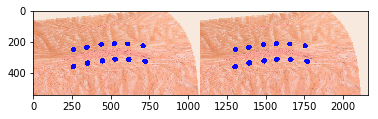

In [15]:
plt.imshow(np.hstack((left_image, right_image)))

In [4]:
tf_listener = tf.TransformListener()
time.sleep(1)
tf_listener.getFrameStrings()

/opt/ros/melodic/lib/python2.7/dist-packages/tf/listener.py:97: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(self._buffer.all_frames_as_yaml()) or {}


['PSM1_clip',
 'PSM2_clip',
 'PSM3_base',
 'simcamera',
 'PSM1_RCM',
 'PSM1',
 'PSM3_clip',
 'PSM2',
 'PSM3',
 'ECM_RCM',
 'ECM_base',
 'ECM',
 'PSM2_base',
 'PSM1_base',
 'PSM3_RCM',
 'PSM2_RCM']

In [5]:
psm1 = dvrk.psm('PSM1')
psm2 = dvrk.psm('PSM2')
psm3 = dvrk.psm('PSM3')
ecm = dvrk.ecm('ECM')

psm1_suj = dvrk.suj('PSM1')
psm2_suj = dvrk.suj('PSM2')
psm3_suj = dvrk.suj('PSM3')
ecm_suj = dvrk.suj('ECM')

while ecm.get_current_position() == PyKDL.Frame() or ecm.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)
while psm1.get_current_position() == PyKDL.Frame() or psm1.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)

In [6]:
from math import radians as r

# ECM_STARTING_JOINT_POS = np.asarray([-0.15669435,  0.17855662,  0.07069676,  0.17411496])
# ECM_STARTING_JOINT_POS = np.asarray([0.0615668 , 0.0523214 , 0.04854392, 0.15809197])
# ECM_STARTING_JOINT_POS = np.asarray([-0.14478268, -0.1293848 ,  0.00261061,  0.043541  ])

#3arm new params
# ECM_STARTING_JOINT_POS = np.asarray([-0.35, -0.1 ,  0.06,  0.03541  ])

# ECM_STARTING_JOINT_POS = np.asarray([0., -0.1 ,  0.05,  0.13541  ])
ECM_STARTING_JOINT_POS = np.asarray([-0.05, -0.12 ,  0.05,  0.04541  ])
ecm.move_joint(ECM_STARTING_JOINT_POS)
# psm1.move_joint(np.asarray(sm1))

sm3 = [r(0.1), r(145), r(-25), r(-80), r(-28), r(0)]
psm3_suj.move_joint(np.asarray(sm3))

In [ ]:
from math import radians as r

sm1 = [0.5, -2.4958207607269287, 2.775073528289795, 0.13962633907794952, -0.5235987901687622]
sm2 = [0.5, 2.6005406379699707, -2.7227137088775635, -0.20943951606750488, -0.7155849933624268]
sm3 = [0.5, 2.3212878704071045, -1.378810167312622, -1.5707963705062866, -0.8901179432868958]
cm = [1.0, -1.2042771577835083, 2.687807083129883, -1.4311699867248535]

sm2 =  [0.5, 2.583087205886841, -2.7925267219543457, -0.10471975803375244, -0.6108652353286743]
sm3 = [0.5, 2.2165682315826416, -1.4486232995986938, -1.5707963705062866, -1.0122909545898438]

psm1_suj.move_joint(np.asarray(sm1))
psm2_suj.move_joint(np.asarray(sm2))
psm3_suj.move_joint(np.asarray(sm3))
ecm_suj.move_joint(np.asarray(cm))

print(psm1_suj.get_current_joint_position())
print(psm2_suj.get_current_joint_position())
print(psm3_suj.get_current_joint_position())
print(ecm_suj.get_current_joint_position())
print('----------------------------------')
print(psm1_suj.get_current_position())
print(psm2_suj.get_current_position())
print(psm3_suj.get_current_position())
print(ecm_suj.get_current_position())

In [ ]:
def move_psm1_suj(a, b, c, d, e, f):
    psm1_suj.move_joint(np.asarray([a, r(b), r(c), r(d), r(e), r(f)]))
interact(move_psm1_suj, a=(0.0,1.0), b=(-180,180), c=(-180,180), d=(-180,180), e=(-180,180), f=(-180,180));

In [ ]:
def move_psm2_suj(a, b, c, d, e, f):
    psm2_suj.move_joint(np.asarray([a, r(b), r(c), r(d), r(e), r(f)]))
interact(move_psm2_suj, a=(0.0,1.0), b=(-180,180), c=(-180,180), d=(-180,180), e=(-180,180), f=(-180,180));

In [ ]:
def move_psm3_suj(a, b, c, d, e, f):
    psm3_suj.move_joint(np.asarray([a, r(b), r(c), r(d), r(e), r(f)]))
interact(move_psm3_suj, a=(0.0,1.0), b=(-180,180), c=(-180,180), d=(-180,180), e=(-180,180), f=(-180,180));

In [ ]:
def move_ecm_suj(a, b, c, d, e, f):
    ecm_suj.move_joint(np.asarray([a, r(b), r(c), r(d), r(e), r(f)]))
interact(move_ecm_suj, a=(0.0,1.0), b=(-180,180), c=(-180,180), d=(-180,180), e=(-180,180), f=(-180,180));

In [19]:
time.sleep(1)
PSM_HOME_POS = np.asarray([0., 0., 0.05, 0., 0., 0.])
psm1.move_joint(PSM_HOME_POS)
psm1.close_jaw()

psm2.move_joint(PSM_HOME_POS)
psm2.close_jaw()

psm3.move_joint(PSM_HOME_POS)
psm3.close_jaw()

True

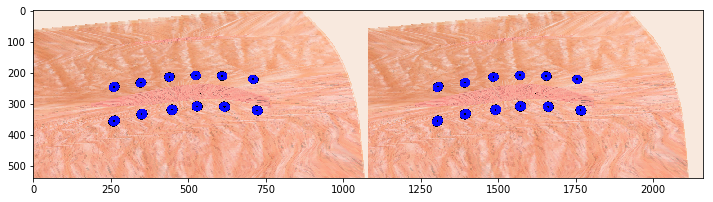

In [7]:
import image_geometry
utils = None
import utils
stereo_model = image_geometry.StereoCameraModel()
stereo_model.fromCameraInfo(left_camera_info, right_camera_info)

tf_cam_to_world = utils.tf_to_pykdl_frame(tf_listener.lookupTransform('simworld', 'simcamera', rospy.Time()))
tf_world_to_psm1 = \
    utils.tf_to_pykdl_frame(tf_listener.lookupTransform('PSM1_base', 'simworld', rospy.Time()))
tf_world_to_psm2 = \
    utils.tf_to_pykdl_frame(tf_listener.lookupTransform('PSM2_base', 'simworld', rospy.Time()))
tf_world_to_psm3 = \
    utils.tf_to_pykdl_frame(tf_listener.lookupTransform('PSM3_base', 'simworld', rospy.Time()))

objects, frame = utils.get_points_and_img(left_image_msg, right_image_msg, stereo_model, tf_cam_to_world)
plt.figure(figsize=(12, 5))
plt.imshow(frame)
for o in objects:
    o = PyKDL.Vector(o.x(), o.y(), o.z())
#     o = PyKDL.Vector(o.x(), o.y(), o.z())

In [ ]:
len(objects)

In [8]:
# pair up points that are across from each other
# x is *more or less* the axis along the wound
paired_pts = []
while objects:
    pt = objects[0]
    objects.remove(pt)
#     pt2 = min(objects, key=lambda obj : abs(obj.x() - pt.x()))
    pt2 = min(objects, key=lambda obj : abs(obj.y() - pt.y()))
    objects.remove(pt2)
#     paired_pts.append(
#         (max(pt, pt2, key=lambda p: p.y()), min(pt, pt2, key=lambda p: p.y())))
    paired_pts.append(
        (max(pt, pt2, key=lambda p: p.x()), min(pt, pt2, key=lambda p: p.x())))

z_val = paired_pts[0][0][2]
print(len(paired_pts)*2-1)
for i in range(len(paired_pts)):
    paired_pts[i][0][2] = z_val
    paired_pts[i][1][2] = z_val
    
print(paired_pts[0][0][1])
print(paired_pts[1][0][1])
paired_pts = sorted(paired_pts,key=lambda p: float(p[0][1]))
print("paired points sorted:")
paired_pts

11
0.0357570813377
0.0242174246667
paired points sorted:


[([    -1.51484,  -0.0273296,    0.648708],
  [    -1.53043,  -0.0261386,    0.648708]),
 ([    -1.51194,  -0.0132561,    0.648708],
  [    -1.52625,  -0.0126788,    0.648708]),
 ([    -1.51056, -0.00119491,    0.648708],
  [    -1.52612, -0.00021853,    0.648708]),
 ([    -1.50983,   0.0109254,    0.648708],
  [    -1.52636,   0.0106532,    0.648708]),
 ([    -1.51094,   0.0242174,    0.648708],
  [    -1.52659,   0.0239657,    0.648708]),
 ([    -1.51318,   0.0357571,    0.648708],
  [    -1.52817,   0.0363152,    0.648708])]

In [9]:
import suturing_state_machine
# from importlib import reload
reload(suturing_state_machine)
reload(utils)
import time

pts_psm1 = paired_pts[:2]
# print(pts_psm1)
# pts_psm1 =  [( [  -1.53043,  -0.0261386,    0.648708],[    -1.51484,  -0.0273296,    0.648708])]
# print(pts_psm1)
pts_psm2 = paired_pts[4:]
pts_psm3 = paired_pts[2:4]

# double PSM same dir
# sm1 = suturing_state_machine.SuturingStateMachine(psm1, tf_world_to_psm1, pts_psm1, arm_name = 'PSM1')  
# sm2 = suturing_state_machine.SuturingStateMachine(psm2, tf_world_to_psm2, pts_psm2, arm_name = 'PSM2')

# start_time = time.clock()
# while not sm1.is_done() or not sm2.is_done():
#     sm1.run_once()
#     sm2.run_once()
#     time.sleep(0.1)
    
# completion_time = time.clock() - start_time
# print("completion time(s): ",completion_time)

# single PSM 
# pts_psm2 = paired_pts

# sm2 = suturing_state_machine.SuturingStateMachine(psm2, tf_world_to_psm2, pts_psm2, arm_name = 'PSM2')

start_time = time.clock()
# while not sm2.is_done():
#     sm2.run_once()
#     time.sleep(0.1)
    

# double PSM opposite dir
sm1 = suturing_state_machine.SuturingStateMachine(psm1, tf_world_to_psm1, pts_psm1, arm_name = 'PSM3')  
sm2 = suturing_state_machine.SuturingStateMachine(psm2, tf_world_to_psm2, pts_psm2, arm_name = 'PSM2')
sm3 = suturing_state_machine.SuturingStateMachine(psm3, tf_world_to_psm3, pts_psm3, arm_name = 'PSM3')


while not sm1.is_done() or not sm2.is_done() or not sm3.is_done():
    sm1.run_once()
    sm2.run_once()
    sm3.run_once()
    time.sleep(0.1)
    
completion_time = time.clock() - start_time
print("completion time(s): ",completion_time)

[([    -1.51484,  -0.0273296,    0.648708], [    -1.53043,  -0.0261386,    0.648708]), ([    -1.51194,  -0.0132561,    0.648708], [    -1.52625,  -0.0126788,    0.648708])]
completion time(s):  63.155198


In [ ]:
dir(psm1)

In [ ]:
ecm.get_current_joint_position()

In [ ]:
psm2.close_jaw()